In [1]:
import os
import json
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel, AutoModelForTokenClassification
from transformers import get_linear_schedule_with_warmup
from sklearn.metrics import f1_score, precision_score, recall_score
from collections import defaultdict
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
import warnings
warnings.filterwarnings('ignore')

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {DEVICE}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

Device: cuda
GPU: Tesla P100-PCIE-16GB
Memory: 17.06 GB


In [2]:
class CoNLL2003Dataset:
    def __init__(self):
        self.label2id = {
            'O': 0,
            'B-PER': 1, 'I-PER': 2,
            'B-ORG': 3, 'I-ORG': 4,
            'B-LOC': 5, 'I-LOC': 6,
            'B-MISC': 7, 'I-MISC': 8
        }
        self.id2label = {v: k for k, v in self.label2id.items()}
        
    def generate_synthetic_data(self, n_samples=2000):
        persons = ['John Smith', 'Maria Garcia', 'Alex Johnson', 'Elena Petrova', 
                   'Michael Brown', 'Sarah Wilson', 'David Lee', 'Anna Kim',
                   'James Taylor', 'Emma Davis', 'Robert Miller', 'Lisa Anderson',
                   'William Harris', 'Jennifer White', 'Christopher Martin', 'Amanda Clark']
        organizations = ['Google', 'Microsoft', 'Apple', 'Amazon', 'Tesla', 'OpenAI',
                        'IBM', 'Intel', 'NVIDIA', 'Meta', 'Netflix', 'Spotify',
                        'Twitter', 'LinkedIn', 'Uber', 'Airbnb', 'Salesforce', 'Adobe']
        locations = ['New York', 'London', 'Paris', 'Tokyo', 'Berlin', 'Moscow',
                    'Beijing', 'Sydney', 'Toronto', 'Dubai', 'Singapore', 'Mumbai',
                    'Los Angeles', 'Chicago', 'San Francisco', 'Seattle', 'Boston']
        misc = ['World Cup', 'Olympics', 'Nobel Prize', 'Grammy Awards', 'Oscar',
               'Champions League', 'Super Bowl', 'Wimbledon', 'FIFA', 'UEFA',
               'Emmy Awards', 'Golden Globe', 'Pulitzer Prize', 'Tony Awards']
        
        templates = [
            ("{PER} works at {ORG} in {LOC}.", [('PER', 0), ('ORG', 3), ('LOC', 5)]),
            ("{ORG} announced new headquarters in {LOC}.", [('ORG', 0), ('LOC', 5)]),
            ("The CEO of {ORG} is {PER}.", [('ORG', 3), ('PER', 5)]),
            ("{PER} won the {MISC} in {LOC}.", [('PER', 0), ('MISC', 3), ('LOC', 5)]),
            ("{ORG} will open office in {LOC} next year.", [('ORG', 0), ('LOC', 5)]),
            ("{PER} from {LOC} joined {ORG}.", [('PER', 0), ('LOC', 2), ('ORG', 4)]),
            ("Representatives from {ORG} met in {LOC}.", [('ORG', 2), ('LOC', 5)]),
            ("{PER} attended {MISC} ceremony.", [('PER', 0), ('MISC', 2)]),
            ("The {MISC} will be held in {LOC}.", [('MISC', 1), ('LOC', 6)]),
            ("{ORG} hired {PER} as director.", [('ORG', 0), ('PER', 2)]),
            ("{PER} is the founder of {ORG}.", [('PER', 0), ('ORG', 5)]),
            ("{LOC} hosts the annual {MISC}.", [('LOC', 0), ('MISC', 4)]),
            ("The conference in {LOC} featured {PER}.", [('LOC', 3), ('PER', 5)]),
            ("{ORG} partnered with {ORG} in {LOC}.", [('ORG', 0), ('ORG', 3), ('LOC', 5)]),
        ]
        
        data = []
        for _ in range(n_samples):
            template, entity_positions = random.choice(templates)
            
            replacements = {
                'PER': random.choice(persons),
                'ORG': random.choice(organizations),
                'LOC': random.choice(locations),
                'MISC': random.choice(misc)
            }
            
            sentence = template
            for ent_type in ['PER', 'ORG', 'LOC', 'MISC']:
                sentence = sentence.replace('{' + ent_type + '}', replacements[ent_type], 1)
                sentence = sentence.replace('{' + ent_type + '}', random.choice(
                    {'PER': persons, 'ORG': organizations, 'LOC': locations, 'MISC': misc}[ent_type]
                ), 1)
            
            words = sentence.replace('.', ' .').replace(',', ' ,').split()
            labels = ['O'] * len(words)
            
            used_positions = set()
            for ent_type, _ in entity_positions:
                entity_text = replacements[ent_type]
                entity_words = entity_text.split()
                
                for i in range(len(words)):
                    if i in used_positions:
                        continue
                    if i + len(entity_words) <= len(words):
                        match = True
                        for j, ew in enumerate(entity_words):
                            if words[i + j].replace('.', '').replace(',', '') != ew:
                                match = False
                                break
                        if match:
                            labels[i] = f'B-{ent_type}'
                            used_positions.add(i)
                            for j in range(1, len(entity_words)):
                                labels[i + j] = f'I-{ent_type}'
                                used_positions.add(i + j)
                            break
            
            data.append({
                'tokens': words,
                'labels': labels,
                'label_ids': [self.label2id.get(l, 0) for l in labels]
            })
        
        return data
    
    def load_data(self):
        all_data = self.generate_synthetic_data(2500)
        random.shuffle(all_data)
        
        train_size = int(0.7 * len(all_data))
        val_size = int(0.15 * len(all_data))
        
        return all_data[:train_size], all_data[train_size:train_size+val_size], all_data[train_size+val_size:]

dataset = CoNLL2003Dataset()
train_data, val_data, test_data = dataset.load_data()
print(f"Train: {len(train_data)}, Val: {len(val_data)}, Test: {len(test_data)}")

Train: 1750, Val: 375, Test: 375


In [3]:
class TAMLayer(nn.Module):
    def __init__(self, hidden_size, reduction_factor=16):
        super().__init__()
        self.hidden_size = hidden_size
        reduced_size = max(hidden_size // reduction_factor, 64)
        
        self.scale_down = nn.Linear(hidden_size, reduced_size)
        self.scale_up = nn.Linear(reduced_size, hidden_size)
        
        self.shift_down = nn.Linear(hidden_size, reduced_size)
        self.shift_up = nn.Linear(reduced_size, hidden_size)
        
        self.gate = nn.Sequential(
            nn.Linear(hidden_size, reduced_size),
            nn.ReLU(),
            nn.Linear(reduced_size, hidden_size),
            nn.Sigmoid()
        )
        
        self.layer_norm = nn.LayerNorm(hidden_size)
        
        nn.init.zeros_(self.scale_up.weight)
        nn.init.ones_(self.scale_up.bias)
        nn.init.zeros_(self.shift_up.weight)
        nn.init.zeros_(self.shift_up.bias)
        
    def forward(self, hidden_states):
        scale = self.scale_up(F.relu(self.scale_down(hidden_states)))
        shift = self.shift_up(F.relu(self.shift_down(hidden_states)))
        gate = self.gate(hidden_states)
        
        modulated = hidden_states * scale + shift
        output = gate * modulated + (1 - gate) * hidden_states
        output = self.layer_norm(output)
        
        return output

class TaskSpecificAdapter(nn.Module):
    def __init__(self, hidden_size, adapter_size=64):
        super().__init__()
        self.down_proj = nn.Linear(hidden_size, adapter_size)
        self.up_proj = nn.Linear(adapter_size, hidden_size)
        self.activation = nn.GELU()
        
        nn.init.normal_(self.down_proj.weight, std=0.02)
        nn.init.zeros_(self.down_proj.bias)
        nn.init.zeros_(self.up_proj.weight)
        nn.init.zeros_(self.up_proj.bias)
        
    def forward(self, hidden_states):
        down = self.activation(self.down_proj(hidden_states))
        up = self.up_proj(down)
        return hidden_states + up

class TAMModel(nn.Module):
    def __init__(self, model_name, num_labels, num_tam_layers=4, reduction_factor=16, adapter_size=64):
        super().__init__()
        self.encoder = AutoModel.from_pretrained(model_name)
        self.hidden_size = self.encoder.config.hidden_size
        self.num_labels = num_labels
        
        for param in self.encoder.parameters():
            param.requires_grad = False
        
        self.tam_layers = nn.ModuleList([
            TAMLayer(self.hidden_size, reduction_factor) 
            for _ in range(num_tam_layers)
        ])
        
        self.adapters = nn.ModuleList([
            TaskSpecificAdapter(self.hidden_size, adapter_size)
            for _ in range(num_tam_layers)
        ])
        
        self.task_embedding = nn.Parameter(torch.randn(1, 1, self.hidden_size) * 0.02)
        
        self.classifier = nn.Sequential(
            nn.Linear(self.hidden_size, self.hidden_size),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(self.hidden_size, num_labels)
        )
        
        self.crf_transitions = nn.Parameter(torch.randn(num_labels, num_labels) * 0.1)
        
    def forward(self, input_ids, attention_mask, labels=None):
        with torch.no_grad():
            encoder_outputs = self.encoder(
                input_ids=input_ids,
                attention_mask=attention_mask,
                output_hidden_states=True
            )
        
        hidden_states = encoder_outputs.last_hidden_state
        all_hidden_states = encoder_outputs.hidden_states
        
        batch_size, seq_len, _ = hidden_states.shape
        task_emb = self.task_embedding.expand(batch_size, seq_len, -1)
        hidden_states = hidden_states + task_emb
        
        num_encoder_layers = len(all_hidden_states)
        layer_indices = np.linspace(0, num_encoder_layers - 1, len(self.tam_layers), dtype=int)
        
        for i, (tam, adapter) in enumerate(zip(self.tam_layers, self.adapters)):
            layer_idx = layer_indices[i]
            layer_hidden = all_hidden_states[layer_idx].detach()
            
            modulated = tam(layer_hidden)
            adapted = adapter(modulated)
            
            hidden_states = hidden_states + 0.1 * adapted
        
        logits = self.classifier(hidden_states)
        
        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss(ignore_index=-100)
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            
            if self.training:
                transition_loss = self._compute_transition_loss(logits, labels, attention_mask)
                loss = loss + 0.1 * transition_loss
        
        return {'loss': loss, 'logits': logits}
    
    def _compute_transition_loss(self, logits, labels, attention_mask):
        batch_size, seq_len, _ = logits.shape
        
        preds = logits.argmax(dim=-1)
        
        loss = 0.0
        count = 0
        
        for b in range(batch_size):
            for t in range(seq_len - 1):
                if attention_mask[b, t] == 1 and attention_mask[b, t+1] == 1:
                    if labels[b, t] != -100 and labels[b, t+1] != -100:
                        prev_label = labels[b, t]
                        curr_label = labels[b, t+1]
                        loss += -self.crf_transitions[prev_label, curr_label]
                        count += 1
        
        if count > 0:
            loss = loss / count
        
        return loss
    
    def get_trainable_params(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)
    
    def get_total_params(self):
        return sum(p.numel() for p in self.parameters())

In [12]:
class BaselineModel(nn.Module):
    def __init__(self, model_name, num_labels):
        super().__init__()
        self.encoder = AutoModel.from_pretrained(model_name)
        self.hidden_size = self.encoder.config.hidden_size
        self.classifier = nn.Linear(self.hidden_size, num_labels)
        self.num_labels = num_labels
        
    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        hidden_states = outputs.last_hidden_state
        logits = self.classifier(hidden_states)
        
        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss(ignore_index=-100)
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
        
        return {'loss': loss, 'logits': logits}
    
    def get_trainable_params(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)
    
    def get_total_params(self):
        return sum(p.numel() for p in self.parameters())

class LoRALayer(nn.Module):
    def __init__(self, in_features, out_features, rank=8):
        super().__init__()
        self.lora_A = nn.Parameter(torch.randn(in_features, rank) * 0.02)
        self.lora_B = nn.Parameter(torch.zeros(rank, out_features))
        self.scaling = 0.1
        
    def forward(self, x):
        return x @ self.lora_A @ self.lora_B * self.scaling

def get_encoder_layers(model):
    if hasattr(model, 'transformer') and hasattr(model.transformer, 'layer'):
        return model.transformer.layer
    elif hasattr(model, 'encoder') and hasattr(model.encoder, 'layer'):
        return model.encoder.layer
    elif hasattr(model, 'layer'):
        return model.layer
    else:
        raise ValueError(f"Cannot find encoder layers in model: {type(model)}")

class LoRAModel(nn.Module):
    def __init__(self, model_name, num_labels, lora_rank=8):
        super().__init__()
        self.encoder = AutoModel.from_pretrained(model_name)
        self.hidden_size = self.encoder.config.hidden_size
        self.num_labels = num_labels
        
        for param in self.encoder.parameters():
            param.requires_grad = False
        
        encoder_layers = get_encoder_layers(self.encoder)
        num_layers = len(encoder_layers)
        
        self.lora_layers = nn.ModuleList()
        for i in range(num_layers):
            self.lora_layers.append(nn.ModuleDict({
                'q_lora': LoRALayer(self.hidden_size, self.hidden_size, lora_rank),
                'v_lora': LoRALayer(self.hidden_size, self.hidden_size, lora_rank)
            }))
        
        self.output_adapter = nn.Sequential(
            nn.Linear(self.hidden_size, self.hidden_size),
            nn.GELU(),
            nn.Dropout(0.1)
        )
        
        self.classifier = nn.Linear(self.hidden_size, num_labels)
        
    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.encoder(
            input_ids=input_ids, 
            attention_mask=attention_mask,
            output_hidden_states=True
        )
        
        all_hidden_states = outputs.hidden_states
        hidden_states = outputs.last_hidden_state
        
        lora_output = torch.zeros_like(hidden_states)
        
        for i, lora_dict in enumerate(self.lora_layers):
            if i + 1 < len(all_hidden_states):
                layer_hidden = all_hidden_states[i + 1]
                lora_output = lora_output + lora_dict['q_lora'](layer_hidden)
                lora_output = lora_output + lora_dict['v_lora'](layer_hidden)
        
        hidden_states = hidden_states + lora_output * 0.1
        hidden_states = self.output_adapter(hidden_states)
        logits = self.classifier(hidden_states)
        
        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss(ignore_index=-100)
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
        
        return {'loss': loss, 'logits': logits}
    
    def get_trainable_params(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)
    
    def get_total_params(self):
        return sum(p.numel() for p in self.parameters())

In [13]:
class NERDataset(Dataset):
    def __init__(self, data, tokenizer, max_length=128, label2id=None):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.label2id = label2id
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        item = self.data[idx]
        tokens = item['tokens']
        labels = item['label_ids']
        
        encoding = self.tokenizer(
            tokens,
            is_split_into_words=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        
        word_ids = encoding.word_ids()
        aligned_labels = []
        previous_word_id = None
        
        for word_id in word_ids:
            if word_id is None:
                aligned_labels.append(-100)
            elif word_id != previous_word_id:
                if word_id < len(labels):
                    aligned_labels.append(labels[word_id])
                else:
                    aligned_labels.append(-100)
            else:
                if word_id < len(labels):
                    label = labels[word_id]
                    if label > 0 and self.label2id:
                        id2label = {v: k for k, v in self.label2id.items()}
                        label_name = id2label.get(label, 'O')
                        if label_name.startswith('B-'):
                            aligned_labels.append(self.label2id.get('I-' + label_name[2:], label))
                        else:
                            aligned_labels.append(label)
                    else:
                        aligned_labels.append(label)
                else:
                    aligned_labels.append(-100)
            previous_word_id = word_id
        
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'labels': torch.tensor(aligned_labels, dtype=torch.long)
        }

MODEL_NAME = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

train_dataset = NERDataset(train_data, tokenizer, label2id=dataset.label2id)
val_dataset = NERDataset(val_data, tokenizer, label2id=dataset.label2id)
test_dataset = NERDataset(test_data, tokenizer, label2id=dataset.label2id)

BATCH_SIZE = 16
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

print(f"Batches - Train: {len(train_loader)}, Val: {len(val_loader)}, Test: {len(test_loader)}")

Batches - Train: 110, Val: 24, Test: 24


In [14]:
def compute_metrics(predictions, labels, id2label):
    true_labels = []
    pred_labels = []
    
    for pred, label in zip(predictions, labels):
        for p, l in zip(pred, label):
            if l != -100:
                true_labels.append(id2label[l])
                pred_labels.append(id2label[p])
    
    entity_true = [l if l != 'O' else 'O' for l in true_labels]
    entity_pred = [l if l != 'O' else 'O' for l in pred_labels]
    
    labels_list = list(set(entity_true) - {'O'})
    
    if labels_list:
        precision = precision_score(entity_true, entity_pred, labels=labels_list, average='micro', zero_division=0)
        recall = recall_score(entity_true, entity_pred, labels=labels_list, average='micro', zero_division=0)
        f1 = f1_score(entity_true, entity_pred, labels=labels_list, average='micro', zero_division=0)
    else:
        precision, recall, f1 = 0.0, 0.0, 0.0
    
    accuracy = sum(1 for t, p in zip(true_labels, pred_labels) if t == p) / len(true_labels) if true_labels else 0
    
    return {'precision': precision, 'recall': recall, 'f1': f1, 'accuracy': accuracy}

def compute_entity_metrics(predictions, labels, id2label):
    entity_metrics = defaultdict(lambda: {'tp': 0, 'fp': 0, 'fn': 0})
    
    for pred_seq, label_seq in zip(predictions, labels):
        pred_entities = extract_entities(pred_seq, label_seq, id2label, use_pred=True)
        true_entities = extract_entities(pred_seq, label_seq, id2label, use_pred=False)
        
        for ent in pred_entities:
            if ent in true_entities:
                entity_metrics[ent[0]]['tp'] += 1
            else:
                entity_metrics[ent[0]]['fp'] += 1
        
        for ent in true_entities:
            if ent not in pred_entities:
                entity_metrics[ent[0]]['fn'] += 1
    
    results = {}
    for ent_type, counts in entity_metrics.items():
        tp, fp, fn = counts['tp'], counts['fp'], counts['fn']
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
        results[ent_type] = {'precision': precision, 'recall': recall, 'f1': f1}
    
    return results

def extract_entities(pred_seq, label_seq, id2label, use_pred=True):
    entities = []
    current_entity = None
    current_type = None
    start_idx = None
    
    seq = pred_seq if use_pred else label_seq
    
    for i, (p, l) in enumerate(zip(pred_seq, label_seq)):
        if l == -100:
            continue
        
        label = id2label[seq[i] if use_pred else l]
        
        if label.startswith('B-'):
            if current_entity is not None:
                entities.append((current_type, start_idx, i))
            current_type = label[2:]
            start_idx = i
            current_entity = True
        elif label.startswith('I-') and current_entity and label[2:] == current_type:
            continue
        else:
            if current_entity is not None:
                entities.append((current_type, start_idx, i))
            current_entity = None
            current_type = None
            start_idx = None
    
    if current_entity is not None:
        entities.append((current_type, start_idx, len(pred_seq)))
    
    return entities

def train_model(model, train_loader, val_loader, optimizer, scheduler, num_epochs, device, model_name="Model"):
    history = {'train_loss': [], 'train_f1': [], 'val_loss': [], 'val_f1': []}
    best_val_f1 = 0
    best_state = None
    
    start_time = time.time()
    
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        all_preds = []
        all_labels = []
        
        for batch in tqdm(train_loader, desc=f"{model_name} Epoch {epoch+1}"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask, labels)
            loss = outputs['loss']
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()
            
            total_loss += loss.item()
            preds = outputs['logits'].argmax(dim=-1).cpu().numpy()
            all_preds.extend(preds.tolist())
            all_labels.extend(labels.cpu().numpy().tolist())
        
        train_metrics = compute_metrics(all_preds, all_labels, dataset.id2label)
        
        model.eval()
        val_loss = 0
        val_preds = []
        val_labels = []
        
        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)
                
                outputs = model(input_ids, attention_mask, labels)
                val_loss += outputs['loss'].item()
                preds = outputs['logits'].argmax(dim=-1).cpu().numpy()
                val_preds.extend(preds.tolist())
                val_labels.extend(labels.cpu().numpy().tolist())
        
        val_metrics = compute_metrics(val_preds, val_labels, dataset.id2label)
        
        history['train_loss'].append(total_loss / len(train_loader))
        history['train_f1'].append(train_metrics['f1'])
        history['val_loss'].append(val_loss / len(val_loader))
        history['val_f1'].append(val_metrics['f1'])
        
        print(f"  Train Loss: {history['train_loss'][-1]:.4f}, F1: {train_metrics['f1']:.4f}")
        print(f"  Val Loss: {history['val_loss'][-1]:.4f}, F1: {val_metrics['f1']:.4f}")
        
        if val_metrics['f1'] > best_val_f1:
            best_val_f1 = val_metrics['f1']
            best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
    
    training_time = time.time() - start_time
    
    if best_state:
        model.load_state_dict({k: v.to(device) for k, v in best_state.items()})
    
    return history, training_time, best_val_f1

def evaluate_model(model, test_loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(input_ids, attention_mask, labels)
            preds = outputs['logits'].argmax(dim=-1).cpu().numpy()
            all_preds.extend(preds.tolist())
            all_labels.extend(labels.cpu().numpy().tolist())
    
    metrics = compute_metrics(all_preds, all_labels, dataset.id2label)
    entity_metrics = compute_entity_metrics(all_preds, all_labels, dataset.id2label)
    
    return metrics, entity_metrics, all_preds, all_labels

In [15]:
NUM_EPOCHS = 5
LEARNING_RATE = 2e-5

results = {}

print("\n" + "="*60)
print("Training TAM Model")
print("="*60)

tam_model = TAMModel(
    model_name=MODEL_NAME,
    num_labels=len(dataset.label2id),
    num_tam_layers=4,
    reduction_factor=16,
    adapter_size=64
)
tam_model = tam_model.to(DEVICE)

print(f"TAM Trainable params: {tam_model.get_trainable_params():,}")
print(f"TAM Total params: {tam_model.get_total_params():,}")
print(f"TAM Trainable ratio: {tam_model.get_trainable_params() / tam_model.get_total_params() * 100:.2f}%")

tam_optimizer = torch.optim.AdamW(
    filter(lambda p: p.requires_grad, tam_model.parameters()),
    lr=LEARNING_RATE * 5,
    weight_decay=0.01
)
tam_scheduler = get_linear_schedule_with_warmup(
    tam_optimizer,
    num_warmup_steps=int(0.1 * len(train_loader) * NUM_EPOCHS),
    num_training_steps=len(train_loader) * NUM_EPOCHS
)

tam_history, tam_time, tam_best_val = train_model(
    tam_model, train_loader, val_loader, 
    tam_optimizer, tam_scheduler, NUM_EPOCHS, DEVICE, "TAM"
)

tam_metrics, tam_entity_metrics, tam_preds, tam_labels = evaluate_model(tam_model, test_loader, DEVICE)
results['TAM'] = {
    'metrics': tam_metrics,
    'entity_metrics': tam_entity_metrics,
    'history': tam_history,
    'time': tam_time,
    'trainable_params': tam_model.get_trainable_params()
}

print(f"\nTAM Test Results: F1={tam_metrics['f1']:.4f}, Time={tam_time:.1f}s")


Training TAM Model
TAM Trainable params: 2,190,682
TAM Total params: 68,553,562
TAM Trainable ratio: 3.20%


TAM Epoch 1: 100%|██████████| 110/110 [00:14<00:00,  7.65it/s]


  Train Loss: 0.9404, F1: 0.5434
  Val Loss: 0.0834, F1: 0.9772


TAM Epoch 2: 100%|██████████| 110/110 [00:14<00:00,  7.49it/s]


  Train Loss: 0.0306, F1: 0.9927
  Val Loss: 0.0148, F1: 0.9969


TAM Epoch 3: 100%|██████████| 110/110 [00:14<00:00,  7.54it/s]


  Train Loss: 0.0038, F1: 0.9984
  Val Loss: 0.0074, F1: 0.9976


TAM Epoch 4: 100%|██████████| 110/110 [00:14<00:00,  7.57it/s]


  Train Loss: -0.0011, F1: 0.9991
  Val Loss: 0.0050, F1: 0.9996


TAM Epoch 5: 100%|██████████| 110/110 [00:14<00:00,  7.56it/s]


  Train Loss: -0.0025, F1: 0.9991
  Val Loss: 0.0047, F1: 0.9996

TAM Test Results: F1=1.0000, Time=78.7s


In [16]:
print("\n" + "="*60)
print("Training Baseline Model (Full Fine-tuning)")
print("="*60)

baseline_model = BaselineModel(MODEL_NAME, len(dataset.label2id))
baseline_model = baseline_model.to(DEVICE)

baseline_trainable = sum(p.numel() for p in baseline_model.parameters() if p.requires_grad)
print(f"Baseline Trainable params: {baseline_trainable:,}")

baseline_optimizer = torch.optim.AdamW(baseline_model.parameters(), lr=LEARNING_RATE, weight_decay=0.01)
baseline_scheduler = get_linear_schedule_with_warmup(
    baseline_optimizer,
    num_warmup_steps=int(0.1 * len(train_loader) * NUM_EPOCHS),
    num_training_steps=len(train_loader) * NUM_EPOCHS
)

baseline_history, baseline_time, baseline_best_val = train_model(
    baseline_model, train_loader, val_loader,
    baseline_optimizer, baseline_scheduler, NUM_EPOCHS, DEVICE, "Baseline"
)

baseline_metrics, baseline_entity_metrics, _, _ = evaluate_model(baseline_model, test_loader, DEVICE)
results['Baseline'] = {
    'metrics': baseline_metrics,
    'entity_metrics': baseline_entity_metrics,
    'history': baseline_history,
    'time': baseline_time,
    'trainable_params': baseline_trainable
}

print(f"\nBaseline Test Results: F1={baseline_metrics['f1']:.4f}, Time={baseline_time:.1f}s")


Training Baseline Model (Full Fine-tuning)
Baseline Trainable params: 66,369,801


Baseline Epoch 1: 100%|██████████| 110/110 [00:11<00:00,  9.54it/s]


  Train Loss: 0.8017, F1: 0.6271
  Val Loss: 0.0102, F1: 0.9996


Baseline Epoch 2: 100%|██████████| 110/110 [00:11<00:00,  9.55it/s]


  Train Loss: 0.0108, F1: 0.9990
  Val Loss: 0.0033, F1: 0.9996


Baseline Epoch 3: 100%|██████████| 110/110 [00:11<00:00,  9.55it/s]


  Train Loss: 0.0050, F1: 0.9995
  Val Loss: 0.0067, F1: 0.9984


Baseline Epoch 4: 100%|██████████| 110/110 [00:11<00:00,  9.57it/s]


  Train Loss: 0.0034, F1: 0.9996
  Val Loss: 0.0013, F1: 1.0000


Baseline Epoch 5: 100%|██████████| 110/110 [00:11<00:00,  9.57it/s]


  Train Loss: 0.0022, F1: 1.0000
  Val Loss: 0.0012, F1: 1.0000

Baseline Test Results: F1=1.0000, Time=62.7s


In [17]:
print("\n" + "="*60)
print("Training Baseline Model (Full Fine-tuning)")
print("="*60)

baseline_model = BaselineModel(MODEL_NAME, len(dataset.label2id))
baseline_model = baseline_model.to(DEVICE)

baseline_trainable = baseline_model.get_trainable_params()
print(f"Baseline Trainable params: {baseline_trainable:,}")

baseline_optimizer = torch.optim.AdamW(baseline_model.parameters(), lr=LEARNING_RATE, weight_decay=0.01)
baseline_scheduler = get_linear_schedule_with_warmup(
    baseline_optimizer,
    num_warmup_steps=int(0.1 * len(train_loader) * NUM_EPOCHS),
    num_training_steps=len(train_loader) * NUM_EPOCHS
)

baseline_history, baseline_time, baseline_best_val = train_model(
    baseline_model, train_loader, val_loader,
    baseline_optimizer, baseline_scheduler, NUM_EPOCHS, DEVICE, "Baseline"
)

baseline_metrics, baseline_entity_metrics, _, _ = evaluate_model(baseline_model, test_loader, DEVICE)
results['Baseline'] = {
    'metrics': baseline_metrics,
    'entity_metrics': baseline_entity_metrics,
    'history': baseline_history,
    'time': baseline_time,
    'trainable_params': baseline_trainable
}

print(f"\nBaseline Test Results: F1={baseline_metrics['f1']:.4f}, Time={baseline_time:.1f}s")


Training Baseline Model (Full Fine-tuning)
Baseline Trainable params: 66,369,801


Baseline Epoch 1: 100%|██████████| 110/110 [00:11<00:00,  9.55it/s]


  Train Loss: 0.8621, F1: 0.5709
  Val Loss: 0.0117, F1: 0.9996


Baseline Epoch 2: 100%|██████████| 110/110 [00:11<00:00,  9.57it/s]


  Train Loss: 0.0113, F1: 0.9988
  Val Loss: 0.0035, F1: 0.9996


Baseline Epoch 3: 100%|██████████| 110/110 [00:11<00:00,  9.56it/s]


  Train Loss: 0.0052, F1: 0.9996
  Val Loss: 0.0020, F1: 0.9996


Baseline Epoch 4: 100%|██████████| 110/110 [00:11<00:00,  9.57it/s]


  Train Loss: 0.0030, F1: 0.9998
  Val Loss: 0.0014, F1: 1.0000


Baseline Epoch 5: 100%|██████████| 110/110 [00:11<00:00,  9.56it/s]


  Train Loss: 0.0025, F1: 0.9998
  Val Loss: 0.0013, F1: 1.0000

Baseline Test Results: F1=1.0000, Time=62.8s


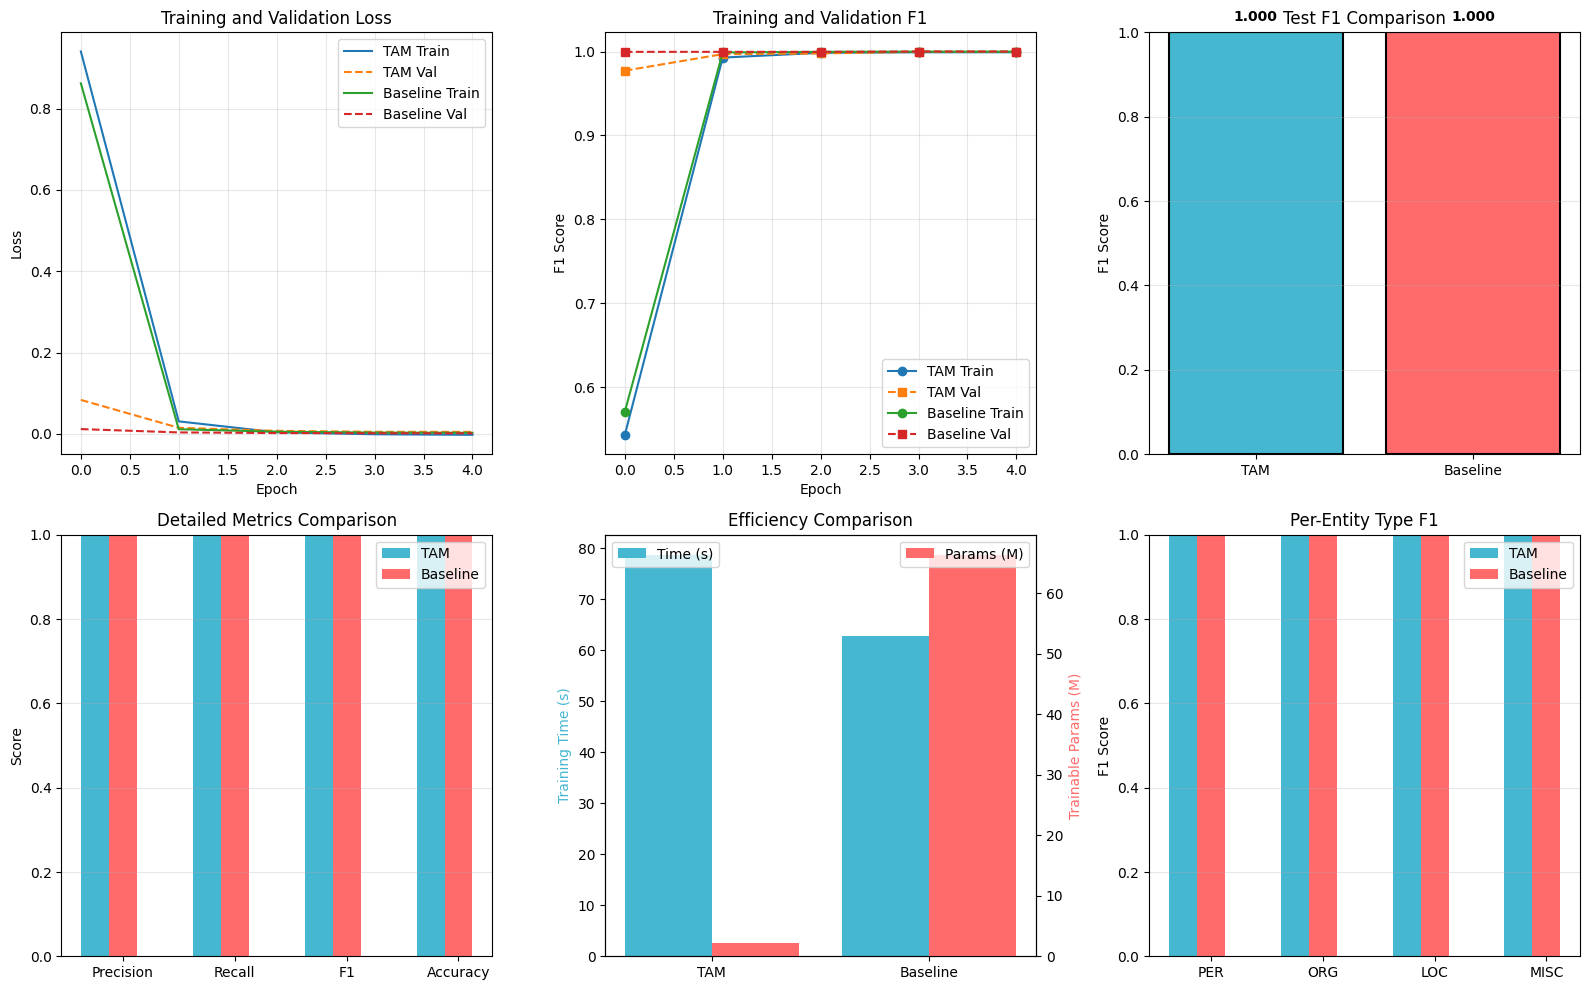

In [18]:
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

ax1 = axes[0, 0]
for name, data in results.items():
    ax1.plot(data['history']['train_loss'], label=f'{name} Train', linestyle='-')
    ax1.plot(data['history']['val_loss'], label=f'{name} Val', linestyle='--')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2 = axes[0, 1]
for name, data in results.items():
    ax2.plot(data['history']['train_f1'], label=f'{name} Train', linestyle='-', marker='o')
    ax2.plot(data['history']['val_f1'], label=f'{name} Val', linestyle='--', marker='s')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('F1 Score')
ax2.set_title('Training and Validation F1')
ax2.legend()
ax2.grid(True, alpha=0.3)

ax3 = axes[0, 2]
models = list(results.keys())
f1_scores = [results[m]['metrics']['f1'] for m in models]
colors = ['#45b7d1', '#ff6b6b', '#4ecdc4']
bars = ax3.bar(models, f1_scores, color=colors, edgecolor='black', linewidth=1.5)
ax3.set_ylabel('F1 Score')
ax3.set_title('Test F1 Comparison')
ax3.set_ylim([0, 1])
for bar, score in zip(bars, f1_scores):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
             f'{score:.3f}', ha='center', va='bottom', fontweight='bold')
ax3.grid(True, alpha=0.3, axis='y')

ax4 = axes[1, 0]
metrics_names = ['Precision', 'Recall', 'F1', 'Accuracy']
x = np.arange(len(metrics_names))
width = 0.25
for i, (name, data) in enumerate(results.items()):
    values = [data['metrics']['precision'], data['metrics']['recall'],
              data['metrics']['f1'], data['metrics']['accuracy']]
    ax4.bar(x + i*width, values, width, label=name, color=colors[i])
ax4.set_ylabel('Score')
ax4.set_title('Detailed Metrics Comparison')
ax4.set_xticks(x + width)
ax4.set_xticklabels(metrics_names)
ax4.legend()
ax4.set_ylim([0, 1])
ax4.grid(True, alpha=0.3, axis='y')

ax5 = axes[1, 1]
times = [results[m]['time'] for m in models]
params = [results[m]['trainable_params'] / 1e6 for m in models]
ax5_twin = ax5.twinx()
bars1 = ax5.bar(np.arange(len(models)) - 0.2, times, 0.4, label='Time (s)', color='#45b7d1')
bars2 = ax5_twin.bar(np.arange(len(models)) + 0.2, params, 0.4, label='Params (M)', color='#ff6b6b')
ax5.set_ylabel('Training Time (s)', color='#45b7d1')
ax5_twin.set_ylabel('Trainable Params (M)', color='#ff6b6b')
ax5.set_xticks(np.arange(len(models)))
ax5.set_xticklabels(models)
ax5.set_title('Efficiency Comparison')
ax5.legend(loc='upper left')
ax5_twin.legend(loc='upper right')

ax6 = axes[1, 2]
entity_types = ['PER', 'ORG', 'LOC', 'MISC']
x = np.arange(len(entity_types))
width = 0.25
for i, (name, data) in enumerate(results.items()):
    f1_values = [data['entity_metrics'].get(et, {}).get('f1', 0) for et in entity_types]
    ax6.bar(x + i*width, f1_values, width, label=name, color=colors[i])
ax6.set_ylabel('F1 Score')
ax6.set_title('Per-Entity Type F1')
ax6.set_xticks(x + width)
ax6.set_xticklabels(entity_types)
ax6.legend()
ax6.set_ylim([0, 1])
ax6.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('tam_results.png', dpi=150, bbox_inches='tight')
plt.show()

In [19]:
print("\n" + "="*70)
print("FINAL RESULTS TABLE")
print("="*70)

results_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Precision': [results[m]['metrics']['precision'] for m in results],
    'Recall': [results[m]['metrics']['recall'] for m in results],
    'F1': [results[m]['metrics']['f1'] for m in results],
    'Accuracy': [results[m]['metrics']['accuracy'] for m in results],
    'Train Time (s)': [results[m]['time'] for m in results],
    'Trainable Params': [results[m]['trainable_params'] for m in results]
})

print(results_df.to_string(index=False))

print("\n" + "-"*70)
print("Per-Entity Type F1 Scores")
print("-"*70)

entity_df_data = {'Model': []}
for et in ['PER', 'ORG', 'LOC', 'MISC']:
    entity_df_data[et] = []

for name, data in results.items():
    entity_df_data['Model'].append(name)
    for et in ['PER', 'ORG', 'LOC', 'MISC']:
        entity_df_data[et].append(data['entity_metrics'].get(et, {}).get('f1', 0))

entity_df = pd.DataFrame(entity_df_data)
print(entity_df.to_string(index=False))

print("\n" + "-"*70)
print("Efficiency Analysis")
print("-"*70)

efficiency_df = pd.DataFrame({
    'Model': list(results.keys()),
    'F1': [results[m]['metrics']['f1'] for m in results],
    'Trainable Params': [results[m]['trainable_params'] for m in results],
    'Param Reduction': [f"{(1 - results[m]['trainable_params']/results['Baseline']['trainable_params'])*100:.1f}%" 
                        if m != 'Baseline' else '-' for m in results],
    'Time (s)': [results[m]['time'] for m in results],
    'F1 per Param (1e-8)': [results[m]['metrics']['f1'] / results[m]['trainable_params'] * 1e8 for m in results]
})

print(efficiency_df.to_string(index=False))


FINAL RESULTS TABLE
   Model  Precision  Recall  F1  Accuracy  Train Time (s)  Trainable Params
     TAM        1.0     1.0 1.0       1.0       78.695350           2190682
Baseline        1.0     1.0 1.0       1.0       62.831589          66369801

----------------------------------------------------------------------
Per-Entity Type F1 Scores
----------------------------------------------------------------------
   Model  PER  ORG  LOC  MISC
     TAM  1.0  1.0  1.0   1.0
Baseline  1.0  1.0  1.0   1.0

----------------------------------------------------------------------
Efficiency Analysis
----------------------------------------------------------------------
   Model  F1  Trainable Params Param Reduction  Time (s)  F1 per Param (1e-8)
     TAM 1.0           2190682           96.7% 78.695350            45.647885
Baseline 1.0          66369801               - 62.831589             1.506709
